# Overview:
- Your goal is to predict the values of single unit properties using the observations from 2017.
- In these exercises, you will run through the stages of exploration as you continue to work toward the above goal. 
- Use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [1]:
# imports: 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import wrangle as wr

## Aquiure and Prepare the data: 

In [2]:
# get the data: 
df = wr.create_zillow_data()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
# prep the data:
df = wr.prep_zillow(df)
df.head()

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941.39,LA
6,3,4.0,1620,847770,2011,10244.94,LA
7,3,2.0,2077,646760,1926,7924.68,LA
11,0,0.0,1200,5328,1972,91.60,LA
14,0,0.0,171,6920,1973,255.17,LA


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   bedrooms   int64  
 1   bathrooms  float64
 2   area       int64  
 3   taxvalue   int64  
 4   yearbuilt  int64  
 5   taxamount  float64
 6   county     object 
dtypes: float64(2), int64(4), object(1)
memory usage: 130.6+ MB


In [11]:
# split the data: 
train, validate, test = wr.split_zillow_data(df)
train.head()

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
1567873,3,1.0,1248,191578,1950,2712.21,LA
1218138,2,2.0,1326,1345206,1950,16539.04,LA
339661,2,1.0,1053,356648,1953,4575.16,LA
1017133,3,2.0,1256,175069,1946,2635.51,LA
40250,3,2.0,1640,543000,1957,6344.96,Orange


In [6]:
# scale the columns using minmaxscaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
to_scale = ['bedrooms', 'bathrooms', 'area', 'yearbuilt', 'taxamount']

In [10]:
# create the object: 
train_scaled = train.copy()
scaler = MinMaxScaler()

In [12]:
# fit and transform the object
train_scaled[to_scale] = scaler.fit_transform(train[to_scale])

In [13]:
# use the object
train_scaled.head()

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
1567873,0.200000,0.03125,0.001309,191578,0.693023,0.002510,LA
1218138,0.133333,0.06250,0.001391,1345206,0.693023,0.015335,LA
339661,0.133333,0.03125,0.001104,356648,0.706977,0.004238,LA
1017133,0.200000,0.06250,0.001317,175069,0.674419,0.002439,LA
40250,0.200000,0.06250,0.001721,543000,0.725581,0.005879,Orange


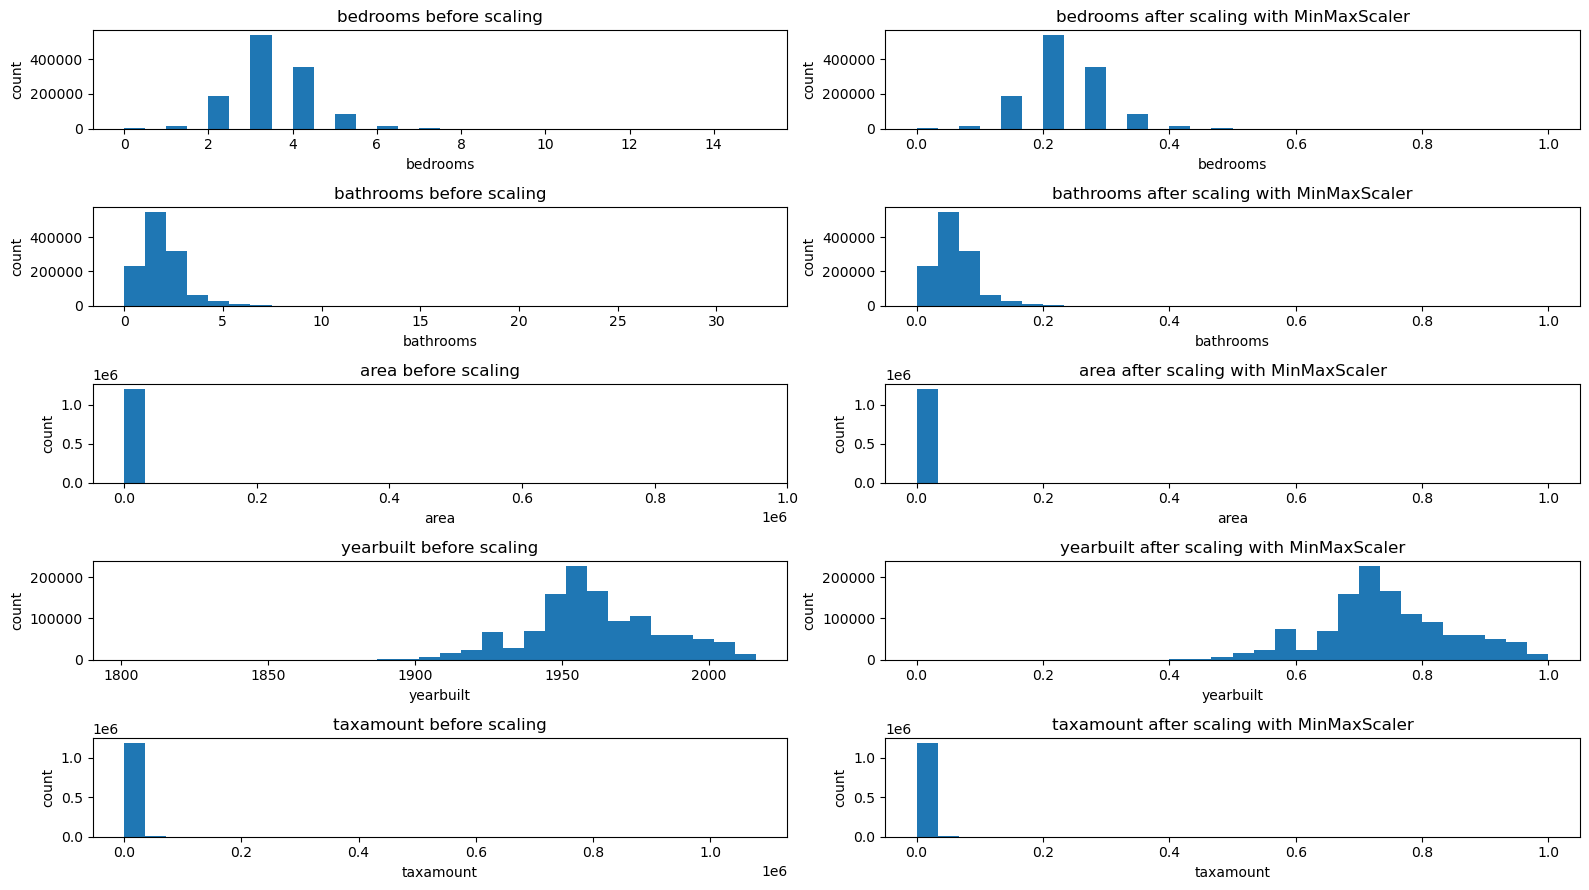

In [15]:
# look at the visualizations: 
import explore as ex
ex.visualize_scaler(scaler=MinMaxScaler(),
                   df = train,
                   columns_to_scale = to_scale,
                   bins = 30)

## Initial Questions: 

1.  Could bedrooms and bathrooms play a part in tax values? Are they stronger influencers apart or togther?
2. Does area impact tax value the most?
3. Does how old the house matter towards the tax value? I would assume older house, due the condition that they may be in, require much more work and therefore will cost less.

## Question 1:
Write a function named `plot_variable_pairs` that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.